In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm


In [11]:
!pip3 install torchvision

     |████████████████████████████████| 1.5 MB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 139.8 MB 7.8 MB/s eta 0:00:011
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1
    Uninstalling torch-1.13.1:
      Successfully uninstalled torch-1.13.1


In [3]:
trans = tv.transforms.Compose([tv.transforms.ToTensor()])

In [4]:
ds_mnist = tv.datasets.MNIST('./datasets', download = True, transform=trans)

In [9]:
ds_mnist[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [5]:
ds_mnist[0][0].shape

torch.Size([1, 28, 28])

In [6]:
ds_mnist[0][0].numpy()[0].shape

(28, 28)

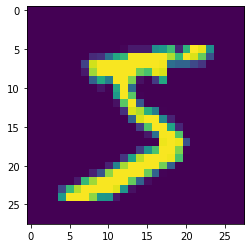

In [7]:
plt.imshow(ds_mnist[0][0].numpy()[0])

In [8]:
batch_size = 16
dataloader = torch.utils.data.DataLoader(ds_mnist, batch_size = batch_size, shuffle=True, num_workers=0, drop_last=True)

In [9]:
for img, label in dataloader:
    print(img.shape)
    print(label.shape)
    break

torch.Size([16, 1, 28, 28])
torch.Size([16])


In [22]:
class Neural_numbers(nn.Module):
    def __init__(self):
        super().__init__()
        flat = nn.Flatten()
        linear1 = nn.Linear(28 * 28, 1000)
        linear2 = nn.Linear(1000, 1000)
        linear3 = nn.Linear(1000, 100)
        linear4 = nn.Linear(100,10)
        act1 = nn.ReLU()
        act2 = nn.ReLU()
        act3 = nn.ReLU()
        act4 = nn.Softmax()
        self.model = nn.Sequential(flat, linear1, act1, linear2, act2, linear3, act3, linear4, act4)

    def forward(self, x):
        return self.model(x)

In [23]:
model = Neural_numbers()

In [24]:
loss_fn = nn.CrossEntropyLoss()

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [26]:
def accuracy(pred, label):
    answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)
    # print(answer)
    # print(answer.sum())
    return answer.mean()

In [27]:
epochs = 4
loss_list = []
ac_list = []
for epoch in range(epochs):
    loss_val = 0
    ac_val = 0
    for img, label in (pbar := tqdm(dataloader)):
        optimizer.zero_grad()
        label = nn.functional.one_hot(label, 10).float()
        pred = model(img)
        loss = loss_fn(pred, label)
        loss.backward()
        loss_item = loss.item()
        loss_val += loss_item
        optimizer.step()
        ac_current = accuracy(pred, label)
        pbar.set_description(f'loss: {loss_item: .4f}')
    loss_list.append(loss_val / len(dataloader))
    ac_list.append(ac_current)
    

  0%|          | 0/3750 [00:00<?, ?it/s]/var/folders/9y/cbn__xb93h3710lq08dsvk9r0000gn/T/ipykernel_93687/710207283.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)
loss:  1.5840: 100%|██████████| 3750/3750 [00:56<00:00, 66.22it/s]


In [35]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

79510

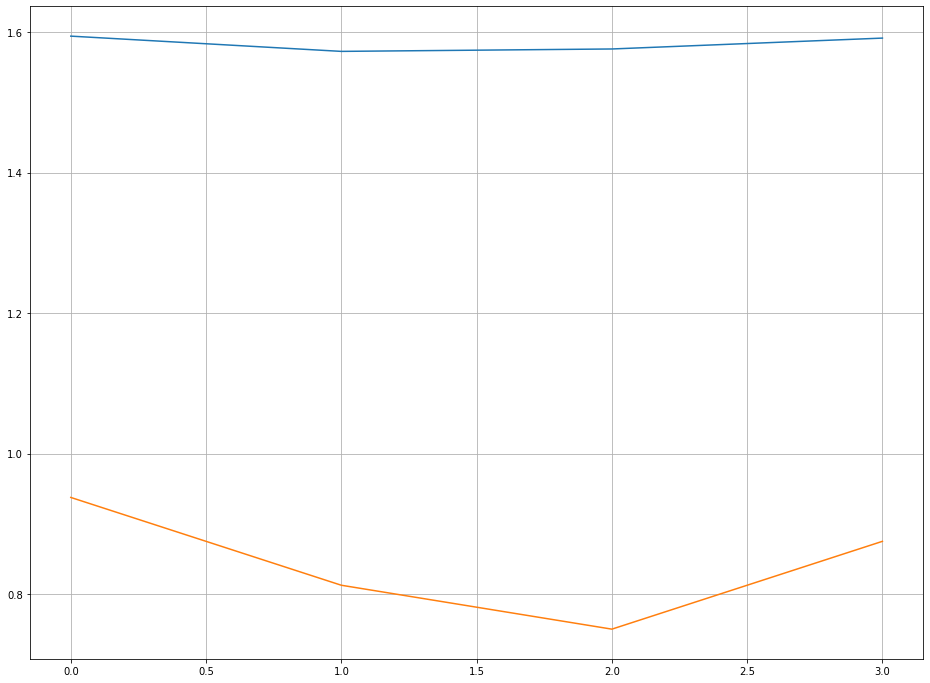

In [28]:
plt.figure(figsize=(16, 12))
plt.plot(np.arange(epochs), np.array(loss_list))
plt.plot(np.arange(epochs), np.array(ac_list))
plt.grid(True)

In [29]:
accuracy(pred, label)

/var/folders/9y/cbn__xb93h3710lq08dsvk9r0000gn/T/ipykernel_93687/710207283.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)


0.875

tensor(6)

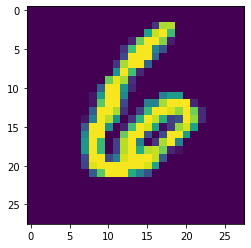

In [30]:
ind = 13
pred = model(ds_mnist[ind][0])
plt.imshow(ds_mnist[ind][0].numpy()[0])
torch.argmax(pred)

In [39]:
img = cv2.bitwise_not(cv2.imread('test7.jpg', cv2.IMREAD_GRAYSCALE))
img = np.expand_dims(img, axis=0)
# img = np.expand_dims(img, axis=0)
img = img.astype(np.float32) / 255.0

tensor(6)

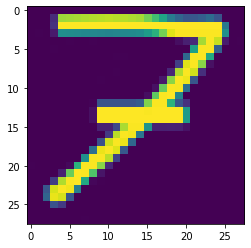

In [40]:
t_img = torch.from_numpy(img)
pred = model(t_img)
plt.imshow(img[0])
pred.argmax()

tensor(8)

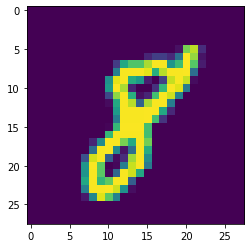

In [21]:
ind = 17
pred = model(ds_mnist[ind][0])
plt.imshow(ds_mnist[ind][0].numpy()[0])
torch.argmax(pred)

<method-wrapper '__invert__' of numpy.ndarray object at 0x7fa8f80c56f0>